# Using GPU Optical Flow Filter in Python

This notebook illustrates how to use the GPU implementation of the optical flow filter in Python.

## 1. Installation

Please follow the installation instructions provided in the **README.md** file in the [GitHub]( https://github.com/jadarve/optical-flow-filter) repository to install the C++ library and Python modules.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.misc as misc

import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt

import flowfilter.plot as fplot
import flowfilter.gpu.flowfilters as gpufilter

## 2. Error performance

The following piece computes optical flow using a **PyramidalFlowFilter** filter object. The filter is configured to 2 image pyramid levels and maximum optical flow of 4 pixels. [2, 4] smooth iterations are performed for at each pyramid level.

The computed flow is compared to ground truth data produced for this sequence using Blender.

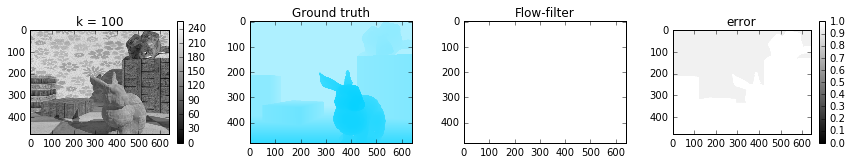

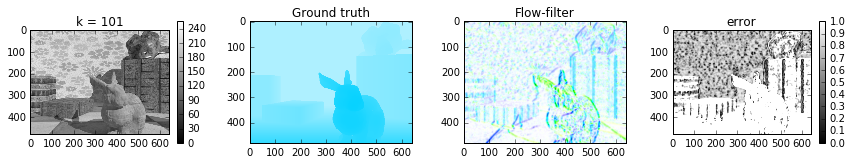

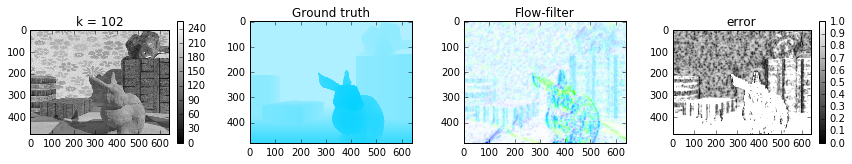

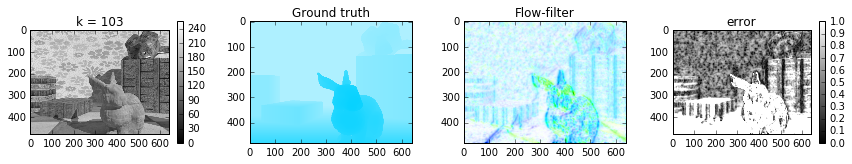

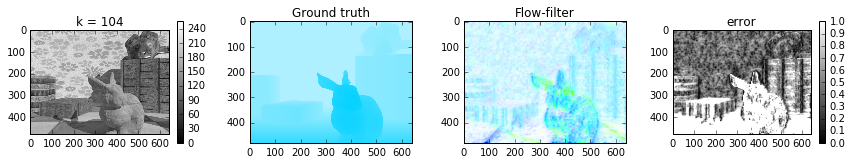

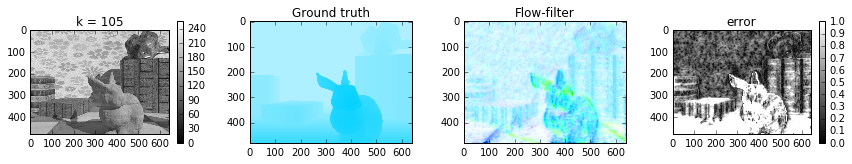

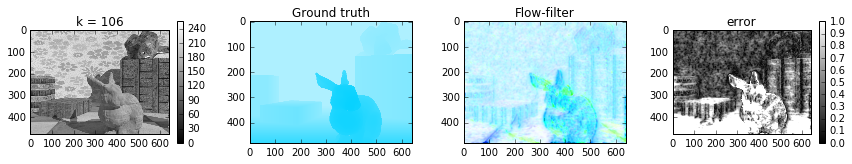

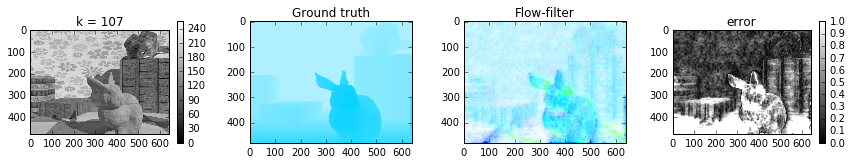

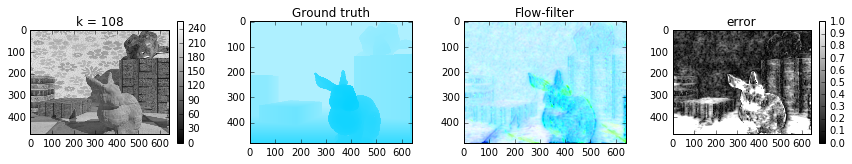

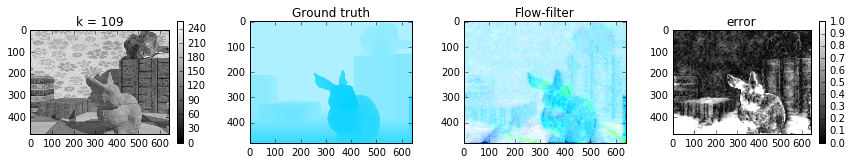

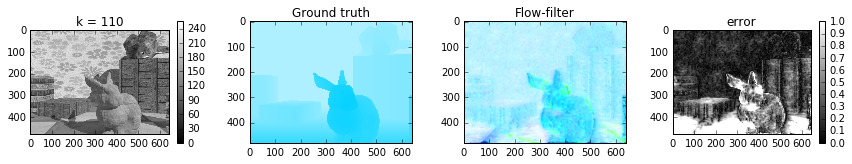

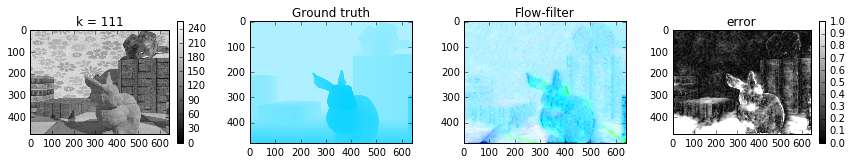

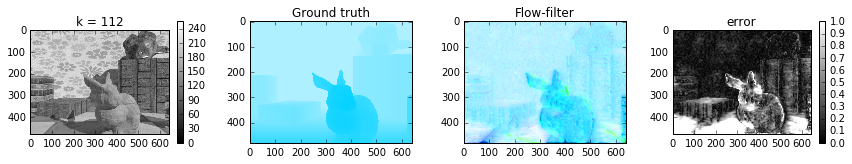

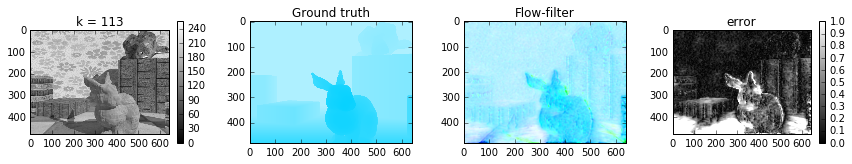

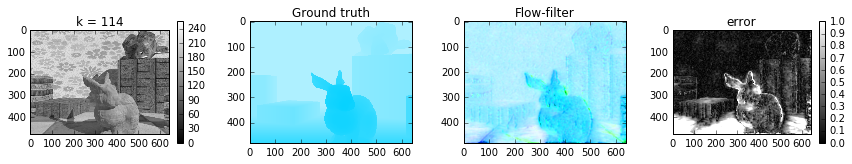

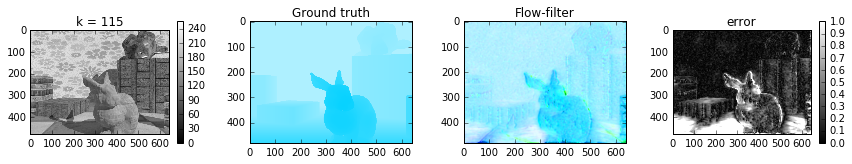

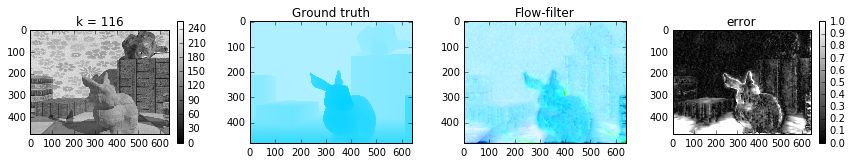

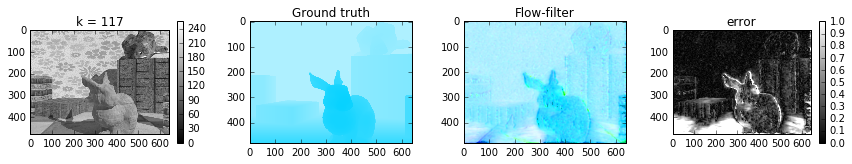

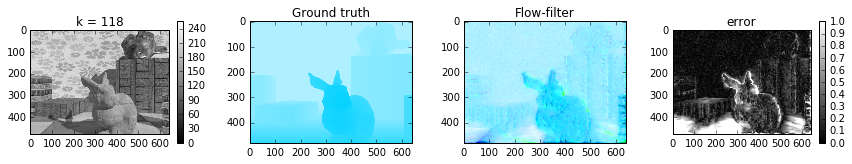

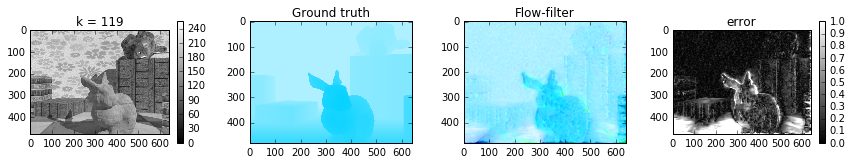

average elapsed time: 1.17239360809 ms


In [5]:
# paths to image and ground truth data
basepath = '/media/jadarve/data/blender/monkey/data/' 
imgpath = basepath + '{0:04d}.jpg'
gtpath = basepath + 'of_{0:04d}.npy'

# GPU filter object with 2 pyramid levels
gpuF = gpufilter.PyramidalFlowFilter(480, 640, 2)
gpuF.gamma = [10, 50]                                   # gains for each level
gpuF.maxflow = 4.0                                      # maximum optical flow value
gpuF.smoothIterations = [2, 4]                          # smooth iterations per level

# print('maxflow: {0}'.format(gpuF.maxflow))
offset = 100
K = 20

avgET = np.zeros(K)
for k in range(offset, offset + K):
    
    ##########################################
    # COMPUTATION
    ##########################################
    
    # read and load next image to the filter
    img = misc.imread(imgpath.format(k), flatten=True).astype(np.uint8)
    gpuF.loadImage(img)
    
    # compute new estimate of optical flow
    gpuF.compute()
    
    # return a Numpy ndarray with the new optical flow estimation
    flow = gpuF.getFlow()
    
    # runtime in milliseconds
    avgET[k - offset] = gpuF.elapsedTime()
    
    
    ##########################################
    # PLOT RESULTS
    ##########################################
    
    # ground truth flow
    flowGT = np.load(gtpath.format(k))
    
    # EndPoint error
    epError = la.norm(flow - flowGT, axis=2)
    
    fig = plt.figure(figsize=(12,2.2)); fig.set_tight_layout(True)
    
    plt.subplot2grid((1,4), (0,0))
    plt.imshow(img, vmin=0, vmax=255, cmap=plt.cm.get_cmap('gray'))
    plt.title('k = {0}'.format(k))
    plt.colorbar()
    
    plt.subplot2grid((1,4), (0,1))
    plt.imshow(fplot.flowToColor(flowGT, 3.0)); plt.title('Ground truth')
    
    plt.subplot2grid((1,4), (0,2))
    plt.imshow(fplot.flowToColor(flow, 3.0)); plt.title('Flow-filter')
                                                                 
    plt.subplot2grid((1,4), (0,3))
    plt.imshow(epError, vmin=0, vmax=1, cmap=plt.cm.get_cmap('gray'))
    plt.title('error')
    plt.colorbar()

    plt.show()

    
print('average elapsed time: {0} ms'.format(np.average(avgET)))

## 3. Runtime performance

The following code snippet measures the average runtime performance of the algorithm. For this, it creates a **PyramidalFlowFilter** object configured with the same parameters as the experiment above.

The parameters that affect runtime performance are:

  * **Pyramid levels**
  * **maxflow** Maximum optical flow allowed in the filter. This parameter directly affects the number of iterations required for the numerical implementation of the prediction stage of the filter.
  * **smooth iterations** Smooth iterations, with average filter, applied after the update stage of the filter.
  
**NOTE**: The measured runtime through the Python wrappers is affected by the overhead of running the Python code. Faster runtimes can be expected in a pure C++ application.

average elapsed time: 0.995867583513 ms


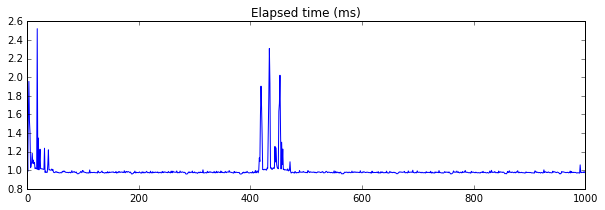

In [4]:
K = 1000

# GPU implementation
gpuF = gpufilter.PyramidalFlowFilter(480, 640, 2)
gpuF.gamma = [10, 50]
gpuF.maxflow = 4.0
gpuF.smoothIterations = [2, 4]

# zeros image to feed the algorithm
img = np.zeros((480, 640), dtype=np.uint8)

avgET = np.zeros(K)

for k in range(K):

    gpuF.loadImage(img)
    gpuF.compute()
    
    # compute time in milliseconds
    avgET[k] = gpuF.elapsedTime()
    

    
print('average elapsed time: {0} ms'.format(np.average(avgET)))

plt.figure(figsize=(10,3))
plt.plot(avgET)
plt.title('Elapsed time (ms)')
plt.show()

## 4. References

    @Article{2016_Adarve_RAL,
      Title                    = {A Filter Formulation for Computing Real Time Optical Flow},
      Author                   = {{Juan David} Adarve and Robert Mahony},
      Journal                  = {Robotics and Automation Letters},
      Year                     = {2016}
    }